In [4]:
import cv2
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import os
import scipy
import yaml
import random

In [2]:
count_figures = 0
all_positions_dict = {}
all_figures_dict = {}

In [3]:
def overlay(background, mask, mask_opacity=0.2, img_opacity=0.7):
    result = cv2.addWeighted(background, img_opacity, mask, mask_opacity, 0)
    plt.imshow(result, cmap='gray')
    plt.title('Check the mask')
    plt.show()

In [ ]:
/home/sasha/WSLProjects/sem_simulator/data/in/bin_masks

In [70]:
path_to_dir= "../sem_simulator/data/in/"

den_dir = os.path.join(path_to_dir, 'denoised')

bin_dir = os.path.join(path_to_dir, 'bin_masks')
orig_dir = os.path.join(path_to_dir, 'raw')
# other = os.path.join(path_to_dir, 'mask_scunet_correct')
filenames_masks = os.listdir(bin_dir)
# filenames.sort()
print(f'Total: {len(filenames_masks)} files')
save_dir = os.path.join(path_to_dir, 'sem_mask')
os.makedirs(path_to_dir + '/sem_mask', exist_ok=True)

Total: 4 files


In [73]:
save_dir

'../sem_simulator/data/in/sem_mask'

In [13]:
def detect_contour(img):
    cont, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    cont_image = np.zeros_like(img)
    cv2.drawContours(cont_image, cont, -1, 255, 0)
    plt.imshow(cont_image) 
    
    return cont, cont_image

In [43]:
def scale_contour(cnt, scale):
    M = cv2.moments(cnt)
    print(M['m10'], M['m00'])
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])

        cnt_norm = cnt - [cx, cy]
        cnt_scaled = cnt_norm * scale
        cnt_scaled = cnt_scaled + [cx, cy]
        cnt_scaled = cnt_scaled.astype(np.int32)

        return cnt_scaled
    return cnt

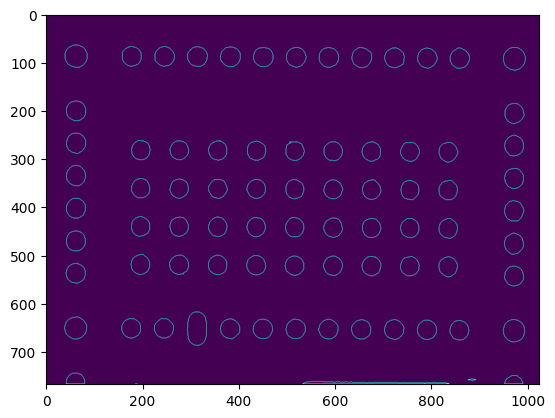

In [49]:
for file_name in filenames_masks:
    bin_mask = cv2.imread(os.path.join(bin_dir, file_name), 0)
    plt.imshow(bin_mask)
    cont, cont_image = detect_contour(bin_mask)
    test = np.zeros_like(bin_mask)
    

In [51]:
cv2.fillConvexPoly(test, cont // 2, 255)  # draws contour resized 1x/2

resized_contour = np.array(cont) * 2
cv2.polylines(test, [resized_contour], isClosed=True, color=255)  # draws contour resized 2x

plt.imshow(test)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

TypeError: unsupported operand type(s) for //: 'tuple' and 'int'

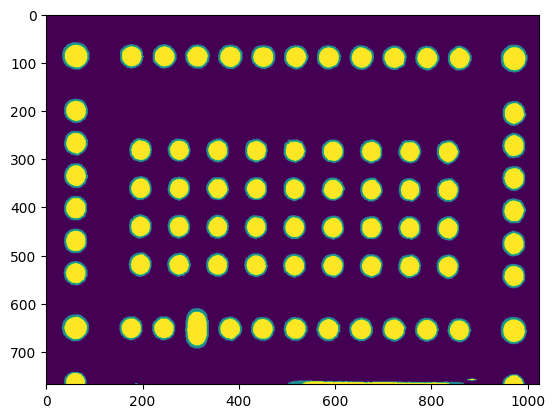

In [74]:
import cv2
import numpy as np

def contour_offset(src, offset):
    return [point + offset for point in src]

def scale_contour(src, scale):
    rct = cv2.boundingRect(src)

    dc_contour = contour_offset(src, (-rct[0], -rct[1]))

    dc_contour_scale = [point * scale for point in dc_contour]
    # print(type(dc_contour_scale))
    rct_scale = cv2.boundingRect(np.array(dc_contour_scale, dtype=np.int32))

    offset = ((rct[2] - rct_scale[2]) // 2, (rct[3] - rct_scale[3]) // 2)
    offset = tuple(np.subtract(offset, (-rct[0], -rct[1])))

    return contour_offset(dc_contour_scale, offset)

def scale_contours(src, scale):
    return [scale_contour(contour, scale) for contour in src]

# Example of usage
if __name__ == "__main__":
    # src = []  # Add your source contours

    for file_name in filenames_masks:
        bin_mask = cv2.imread(os.path.join(bin_dir, file_name), 0)
        # plt.imshow(bin_mask)
        cont, cont_image = detect_contour(bin_mask)
        dst = scale_contours(cont, 1.2)
        dst_np = [np.array(contour, dtype=np.int32) for contour in dst]
        # print(cont, dst)

        cv2.drawContours(cont_image, dst_np, -1, 128, -1)
        cv2.drawContours(cont_image, cont, -1, 255, -1)

        plt.imshow(cont_image)
        cv2.imwrite(os.path.join(save_dir, file_name), cont_image)



In [33]:
scaled_contour

array([[[185, 767]]], dtype=int32)